In [27]:
# I chose NLP as the deep learning topic.
# This is a simple model that performs binary classification on the spam status of messages.
# The following dataset was used: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [2]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('spam.csv', encoding='Windows-1252', header=0, usecols=[0,1], names=['label', 'message'])

# Display the head
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Preprocessing
# Label Encoding: Assigning binary values to labels, very straightforward.
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Text cleaning: Values are lowercased and cleansed of non-alphabetic characters.
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    return text

df['message'] = df['message'].apply(clean_text)

# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
max_vocab_size = 8540 # This was found through the logged values in some of the following cells, than changed later. 
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df['message'])

# Tokenization: Conversion of texts to sequences.
# Each message is converted to a list of integers representing the word's index in the vocab. Very straightforward.
sequences = tokenizer.texts_to_sequences(df['message'])

# Sequence Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 100 # Arbitrarily set to 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
# Because of the needd of the neural networks to receive inputs of same dimensions, I applied padding.
# "padding='post'" just means that the zero paddings are added to the end.

In [4]:
print(f"Max value in padded sequences: {np.max(padded_sequences)}")
print(f"Min value in padded sequences: {np.min(padded_sequences)}")

Max value in padded sequences: 8539
Min value in padded sequences: 0


In [5]:
# Train, test and validation split
from sklearn.model_selection import train_test_split

# Initial split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    padded_sequences, df['label'], test_size=0.2, random_state=42
)

# Second split for validation set.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.125, random_state=42
)

# With the steps above, the data has been fractionized in the following order:
    # Train: 70%
    # Test: 20%
    # Validation: 10%

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 3899 samples
Validation set: 558 samples
Test set: 1115 samples


In [6]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Sample input: {X_train[0]}")

Vocabulary size: 8540
X_train shape: (3899, 100)
y_train shape: (3899,)
Sample input: [ 40   4 844 102  15  33   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [7]:
# Building the Model

# Model Definition
embedding_dim = 32  # Representing each word as a 32 dimensional vector
max_length = X_train.shape[1] # Set to the length of padded sequences for compatibility

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
model = Sequential([
    Embedding(input_dim=8540, output_dim=embedding_dim), # The word embedding layer, using the vocab size and the output shape as defined above
    SimpleRNN(units=128, return_sequences=False), 
    Dropout(0.15),
    Dense(1, activation='sigmoid')  # Sigmoid is best for binary classification
])

model.build(input_shape=(None, max_length))

from tensorflow.keras.optimizers import Adam
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), # Used the Adam optimizer for efficient gradient descent
              loss='binary_crossentropy', # Classic loss function fotr binary classification
              metrics=['accuracy'])

# Print Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │         273,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,017 (1.12 MB)

 Trainable params: 294,017 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=12,  
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8362 - loss: 0.4329 - val_accuracy: 0.8728 - val_loss: 0.3823
Epoch 2/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8725 - loss: 0.3901 - val_accuracy: 0.8728 - val_loss: 0.3823
Epoch 3/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8178 - loss: 0.4641 - val_accuracy: 0.8728 - val_loss: 0.3898
Epoch 4/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8526 - loss: 0.4205 - val_accuracy: 0.8817 - val_loss: 0.3581
Epoch 5/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9063 - loss: 0.2867 - val_accuracy: 0.9247 - val_loss: 0.2831
Epoch 6/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9386 - loss: 0.1983 - val_accuracy: 0.9301 - val_loss: 0.2316
Epoch 7/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9521 - loss: 0.1448 - val_accuracy: 0.8584 - val_loss: 0.4146
Epoch 8/12
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7839 - loss: 0.5086 - val_accuracy: 0

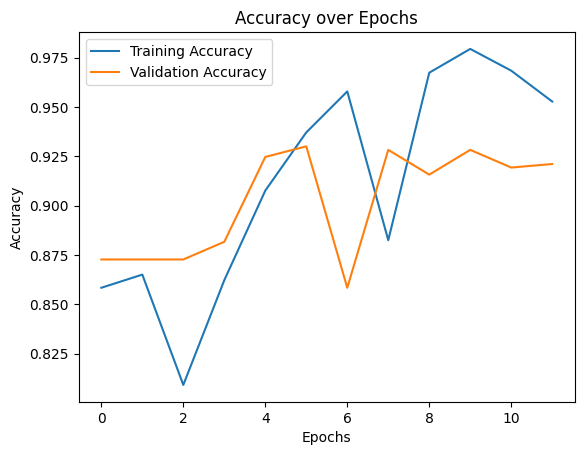

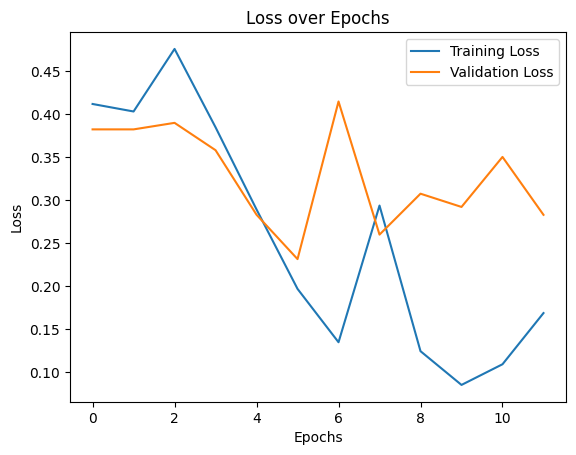

In [9]:
import matplotlib.pyplot as plt

# Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training & Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9262 - loss: 0.2368
Test Loss: 0.2550615966320038
Test Accuracy: 0.9282511472702026


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


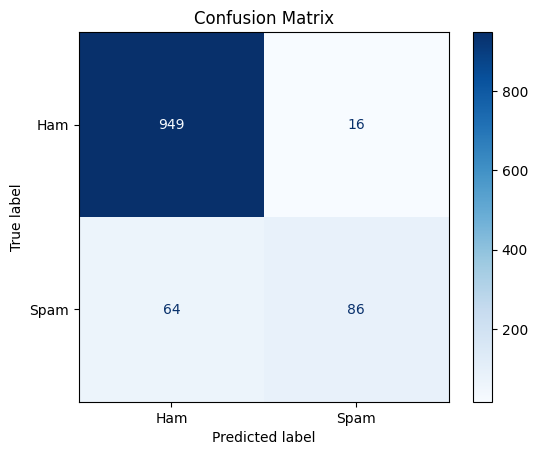

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Threshold at 0.5

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# FINAL - COMMENTS ON OVERFITTING
# Based on observations, I can say that there is no remarkable overfitting going on.
    # Reason 1: Training and Validation Accuracy:
        # The gap between them is very small, which means that the model does a good job on generalizing to unknown data.
    # Reason 2: Validation Loss Behavior:
        # Validation Loss is stable throughout training and it does not increase whike the training loss decreases.
        # If overfitting was present, we would have to see the validation loss rising up as the model overfits the training data.
    # Reason 3: Test Accuracy
        # Test accuracy is pretty close to the validation accuracy, reinforcing the absence of overfitting.